eigen values= [1 2 3 4]
A= [[ 2.11736898 -0.93114402 -0.5907143  -0.51462984]
 [-0.93114402  1.97970616  0.12573883  0.20790849]
 [-0.5907143   0.12573883  2.21400889 -0.06273126]
 [-0.51462984  0.20790849 -0.06273126  3.68891598]]
b= [0.32085204 0.67897001 0.07575555 0.65598383]


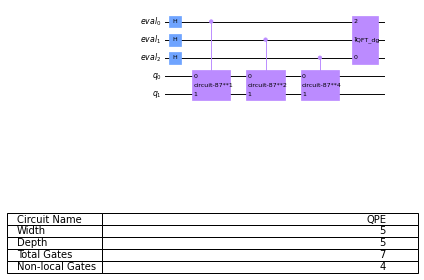

In [1]:
# 3.3.2 HHL algorithm
import numpy as np
from qiskit import *
%matplotlib inline
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library import RYGate
from qiskit.tools.jupyter.library import _generate_circuit_library_visualization
from math import pi
from scipy.linalg import expm

# Solve Ax=b
# setup matrix A and right-hand-side b
# A is a random (2**n)x(2**n) real matrix with eigenvalues [1,2,...,2**n] 
# b is a random normalized real (2**n)-vector

n=2 # vector dimension is 2**n. 
t=3 # number of digits for eigenvalue representation. n<t.

eigens=np.arange(1,2**n+1)
print('eigen values=',eigens)
A=np.random.rand(2**n,2**n)
(Q,R)=np.linalg.qr(A)
A=np.matmul(Q,np.matmul(np.diag(eigens),Q.T))

b=np.random.rand(2**n)-0.5
b=b/np.linalg.norm(b)

print('A=',A)
print('b=',b)

scale=2**t
expA=expm(pi*2j*A/scale)

# generate and check the QPE part of the circuit
unitary = QuantumCircuit(n)
unitary.unitary(expA,[i for i in range(n)])
qpe = PhaseEstimation(t, unitary)
_generate_circuit_library_visualization(qpe)
invqpe=qpe.inverse()
#_generate_circuit_library_visualization(invqpe)


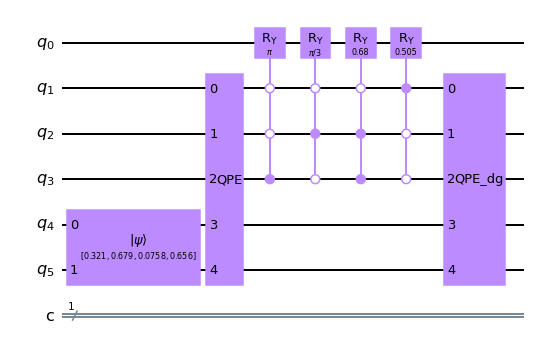

In [2]:
# create the full circuit
qr=QuantumRegister(1+t+n,'q')
cr=ClassicalRegister(1,'c')

circuit = QuantumCircuit(qr,cr)
circuit.initialize(b,[j for j in range(1+t,1+t+n)])
circuit.append(qpe,qr[1:])

for i in range(2**n):
    ctrl_state_i=(format(eigens[i],'0'+str(t)+'b')[::-1])
    #print(ctrl_state_i)
    cr=RYGate(2*np.arcsin(1/eigens[i])).control(t,ctrl_state=ctrl_state_i)
    circuit.append(cr,([j for j in range(1,t+1)]+[0]))

circuit.append(invqpe,qr[1:])
circuit.draw('mpl')


In [3]:
# result and (optional) city diagram 
backend = Aer.get_backend('statevector_simulator')
job = execute(circuit, backend)
result = job.result()
outputstate = result.get_statevector(circuit, decimals=4)
#plot_state_city(outputstate)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
#print(outputstate)
# post-select solution components
solvec=np.zeros(2**n)*1j

for i in range(2**(1+t+n)):
    bitstr=format(i,'0'+str(1+t+n)+'b')
    #print(bitstr,outputstate[i])
    if bitstr[n:]==format(1,'0'+str(t+1)+'b'):
        #print('select',bitstr)
        #print('add to',int(bitstr[0:n]))
        solvec[int(bitstr[0:n],2)]+=outputstate[i]


print('======================')
print('A=',A)
print('b=',b)
x=np.linalg.solve(A,b)
print('======================')
print('HHL solution=',solvec)
print('Numpy solution=',x)
print('======================')

A= [[ 2.11736898 -0.93114402 -0.5907143  -0.51462984]
 [-0.93114402  1.97970616  0.12573883  0.20790849]
 [-0.5907143   0.12573883  2.21400889 -0.06273126]
 [-0.51462984  0.20790849 -0.06273126  3.68891598]]
b= [0.32085204 0.67897001 0.07575555 0.65598383]
HHL solution= [0.4785+0.j 0.5365+0.j 0.1376+0.j 0.2167+0.j]
Numpy solution= [0.47852948 0.5365458  0.13755949 0.21668323]
